In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
g = 9.81
m1 = 1.0
m2 = 1.0
l1 = 1.0
l2 = 1.0

def f_q(q, r, u, v, t):
    q_prime = u
    return q_prime

def f_r(q, r, u, v, t):
    r_prime = v
    return r_prime

def f_u(q, r, u, v, t):
    num = -g * (2 * m1 + m2) * np.sin(q) - m2 * g * np.sin(q - 2 * r) - \
        2 * np.sin(q - r) * m2 * (v ** 2 * l2 + u ** 2 * l1 * np.cos(q - r))
    den = l1 * (2 * m1 + m2 - m2 * np.cos(2 * q - 2 * r))
    u_prime = num / den
    return u_prime

def f_v(q, r, u, v, t):
    num = 2 * np.sin(q - r) * (u ** 2 * l1 * (m1 + m2) + g * (m1 + m2) * np.cos(q) + v ** 2 * l2 * m2 * np.cos(q - r))
    den = l2 * (2 * m1 + m2 - m2 * np.cos(2 * q - 2 * r))
    v_prime = num / den
    return v_prime

def f_qruv(q, r, u, v, t):
    args = (q, r, u, v, t)
    qruv_prime = np.array([
        f_q(*args),
        f_r(*args),
        f_u(*args),
        f_v(*args),
    ])
    return qruv_prime

def x1(q, r):
    val = l1 * np.sin(q)
    return val

def y1(q, r):
    val = -l1 * np.cos(q)
    return val

def x2(q, r):
    val = x1(q, r) + l2 * np.sin(r)
    return val

def y2(q, r):
    val = y1(q, r) - l2 * np.cos(r)
    return val

In [61]:
q0 = np.deg2rad(175)
r0 = np.deg2rad(174)
u0 = 0.0
v0 = 0.0
t0 = 0

h = 0.05
T = 5
t = np.mgrid[t0 : T : h]
    
qruvti = np.array([q0, r0, u0, v0, t0])
history = []

for ti in t:
    history += [qruvti]
    
    k1 = h * f_qruv(*qruvti)
    
    offset = 0.5 * np.array([*k1, h])
    k2 = h * f_qruv(*(qruvti + offset))
    
    offset = 0.5 * np.array([*k2, h])
    k3 = h * f_qruv(*(qruvti + offset))
    
    offset = 1.0 * np.array([*k3, h])
    k4 = h * f_qruv(*(qruvti + offset))
    
    offset = np.concatenate((1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4), (h,)))
    qruvti = qruvti + offset
    
state = []
for q, r, u, v, t in history:
    state += [[x1(q, r), y1(q, r), x2(q, r), y2(q, r), q, r, t]]
state = np.array(state)

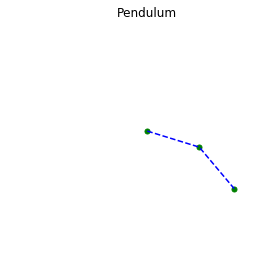

In [62]:
from matplotlib.animation import FuncAnimation

def get_savepath(title):
    fname = title.lower().replace(' ', '_')
    savepath = f'../images/{fname}.gif'
    return savepath


def get_limits():
    min_vals = [-2, -2]
    max_vals = [2, 2]
    limits = np.vstack((min_vals, max_vals))
    return limits.T


def configure_axes(ax, title, limits):
    ax.set_title(title)
    ax.set_xlim(limits[0, :])
    ax.set_ylim(limits[1, :])
    ax.set_aspect('equal')
    ax.set_axis_off()


class Plotter:
    '''Maintains state for FuncAnimation'''
    
    def __init__(self, state, title, incr):
        self.state = state
        self.incr = incr
        self.title = title
        self.fig, self.ax = plt.subplots()

    def init_ani(self):
        limits = get_limits()
        configure_axes(self.ax, self.title, limits)
        self.masses = self.ax.scatter([], [], s=25, c='green')
        self.arms, = self.ax.plot([], [], c='blue', linestyle='dashed')
        return self.masses, self.arms
    
    def step(self, frame):
        index = self.incr * frame
        xy = self.state[index, :4].reshape(2, 2)
        xy = np.concatenate((np.zeros((1, 2)), xy), axis=0)
        self.masses.set_offsets(xy)
        self.arms.set_xdata(xy[:, 0])
        self.arms.set_ydata(xy[:, 1])
        return self.masses, self.arms
    
    def animate(self, savepath):
        num_points = len(self.state)
        frames = num_points // self.incr

        kwargs1 = dict(fig=self.fig, func=self.step, init_func=self.init_ani)
        kwargs2 = dict(frames=frames, interval=50, repeat=False, blit=True)

        ani = FuncAnimation(**kwargs1, **kwargs2)
        ani.save(savepath, dpi=80, writer='imagemagick')
        
def main():
    title = 'Pendulum'
    plotter = Plotter(state, title, incr=1)
    savepath = get_savepath(title)
    plotter.animate(savepath)

main()